# Preparing the data to be run on the MIOFlow notebooks.

In [17]:
import phate
import scprep
import meld
import pandas as pd
import scanpy as sc
import os

In [18]:
data_path = '../../data/raw/cyclicEMT/DN48_Output_Table_20241008.parquet'

In [19]:
df = pd.read_parquet(data_path)

In [20]:
# Read the columns of interest from the text file
interest_columns = '../../data/raw/cyclicEMT/interest_columns/upperquartile_intensity_columns.txt'
with open(interest_columns, 'r') as file:
    columns_of_interest = [line.strip() for line in file]

In [21]:
# Randomly sample 20000 rows
df = df.sample(n=20000, random_state=42)

In [22]:
# Filter the DataFrame to keep only the columns in the text file
df_filtered = df[df.columns.intersection(columns_of_interest)]
df_filtered = df_filtered.dropna()
df_filtered.shape

(20000, 66)

In [23]:
#Drop metadata related columns
df_processed = df_filtered.drop(['Cellprof_Metadata_Well_ID','Metadata_Field','EM_Class','CC_Class','006_Metadata_Treatment'],axis=1)
df_processed.shape

(20000, 61)

In [24]:
# Drop rows with missing values
df_processed = df_processed.dropna()
# Drop columns with missing values
df_processed = df_processed.dropna(axis=1)
#Drop cols with unique values
df_processed = df_processed.loc[:, df_processed.nunique() > 1]
df_processed.shape


(20000, 61)

In [25]:
cell_class = df_filtered['EM_Class']
time_label = df_filtered['006_Metadata_Treatment']
cell_cycle_label = df_filtered['CC_Class']
cell_class.shape

(20000,)

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='Library size', ylabel='Number of cells'>

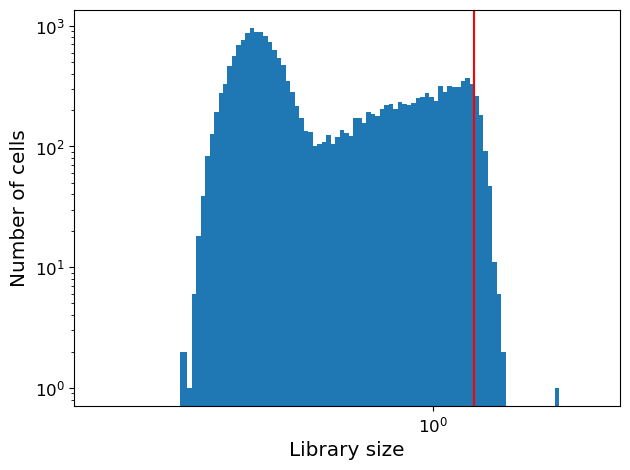

In [26]:
percentile = 97
scprep.plot.plot_library_size(df_processed, percentile=percentile)

In [27]:
#Need to pass the cell_class so the labels will be maintained when removing cells.

df_cleaned,cell_class = scprep.filter.filter_library_size(df_processed, sample_labels= cell_class, percentile=percentile, keep_cells='below')
df_cleaned,time_label = scprep.filter.filter_library_size(df_processed, sample_labels= time_label, percentile=percentile, keep_cells='below')
df_cleaned,cell_cycle_label = scprep.filter.filter_library_size(df_processed, sample_labels= cell_cycle_label, percentile=percentile, keep_cells='below')


df_cleaned.shape

(19400, 61)

In [28]:
df_cleaned = scprep.filter.filter_rare_genes(df_cleaned, min_cells=10000)
df_cleaned = scprep.normalize.library_size_normalize(df_cleaned)
df_cleaned.shape

(19400, 60)

In [29]:
obs_df = pd.DataFrame({
    'time_label': time_label,
    'cell_class': cell_class,
    'cell_cycle_label' : cell_cycle_label
})

In [30]:
adata_emt = sc.AnnData(X=df_cleaned,obs=obs_df)

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
data_name = 'cyclicEMT'
PROCESSED_DATA_DIR = os.path.join('../../data', 'processed',data_name)

adata_emt.write(os.path.join(PROCESSED_DATA_DIR, 'adata.h5ad'))